In [1]:
import numpy as np
import pyfar as pf
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline # this is for the spline interpulation of step 7
from scipy.special import i0 # This is the von Mises PDF also for step 7

In [2]:
sig_path = []
#sig_path = "/Users/orberebi/Documents/GitHub/TUB-BGU-colab/dry_signals/white-noise-burst.wav"
#sofa_path = "/Users/orberebi/Desktop/TUB/Erratum - Modeling sound-source localization in sagittal planes for human listeners/amtoolbox-full-1.5.0/auxdata/baumgartner2014/ARI_Ref_hrtf_M_dtf 256.sofa"
sofa_path = "/Users/orberebi/Documents/GitHub/TUB-BGU-colab/HRTF/KU100-DTF.sofa"
# load sofa file with DTF 
target        = pf.io.read_sofa(sofa_path)[0]
coardinate    = pf.io.read_sofa(sofa_path)[1]
template      = pf.io.read_sofa(sofa_path)[0]
if sig_path:
    stim          = pf.io.read_audio(sig_path) #make sure to match the fs of the DTF and stimulus
else:
    stim = []

print(stim)
# get some parameters from the input data
# Get the DTF of the median plane (azimuth == 0 or 180)
az_mask = np.squeeze(np.logical_or(coardinate.azimuth == 0, coardinate.azimuth == np.pi))
coardinate_median_plane = coardinate[az_mask]
sort = np.argsort(coardinate_median_plane.polar)
coardinate_median_plane = coardinate_median_plane[sort]

target = target[az_mask,:]
target = target[sort]

template = template[az_mask,:]
template = template[sort]

m_sp_directions = target.cshape[0]
ch = target.cshape[1]
t_sample = target.n_samples
fs = int(target.sampling_rate)



print("number of samples on the saggital (median) plane: ",m_sp_directions)
print("time samples of HRTF: ",t_sample)
print("fs = ",fs," [Hz]")





[]
number of samples on the saggital (median) plane:  60
time samples of HRTF:  512
fs =  48000  [Hz]


<Axes3D: xlabel='x in m', ylabel='y in m', zlabel='z in m'>

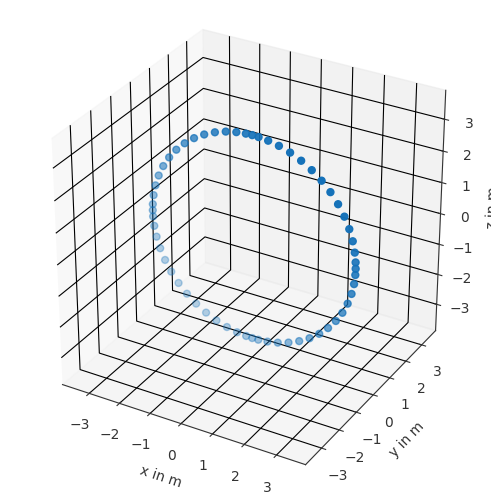

In [3]:
coardinate_median_plane.show()

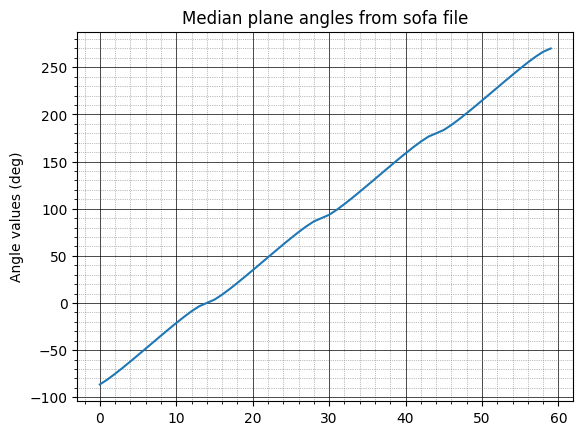

In [33]:
foo = np.rad2deg(coardinate_median_plane.polar)
plt.plot(foo)
plt.ylabel('Angle values (deg)')
plt.title("Median plane angles from sofa file")
plt.grid(which='major', linestyle='-', linewidth='0.5', color='black')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='gray')
plt.minorticks_on()
plt.show()


In [5]:
# Step 1: DTF filtering Eq.(1)
# The target is being time convolve with the stimuli, creating the directional target signal
# ----
if stim:
    target = pf.dsp.convolve(target,stim)
else:
    target = target


This is the signals after the gammatone filtering
time domain energy Signal:
(28, 60, 2) channels with 512 samples @ 48000.0 Hz sampling rate and none FFT normalization



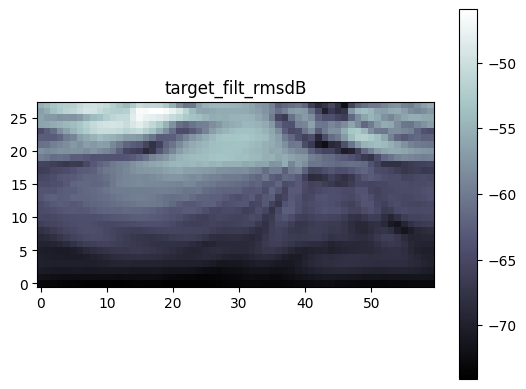

In [6]:
def do_rms(sig):
    # Averaging over time (RMS)
    # Calculate root mean square (rms) along the last axis
    rms_values = np.sqrt(np.mean(np.square(sig.time), axis=-1))
    # Squeeze the array to remove axes with length 1
    rms_values_squeezed = np.squeeze(rms_values)
    # Convert to dB scale
    sig_rms_dB = 20 * np.log10(rms_values_squeezed)
    return sig_rms_dB
    
# Step 2: Spectral Analysis Eq.(2)
# in this step, both traget and template are filtered using gammatone filterbanks
# ----
Gammatones     = pf.dsp.filter.GammatoneBands(freq_range=[700, 20e3],sampling_rate=fs) # Create the filter bank
target_filt    = Gammatones.process(target)[0] # Apply the filter bank (T)
template_filt  = Gammatones.process(template)[0] # Apply the filter bank

print("This is the signals after the gammatone filtering")
print(target_filt)

target_filt_rmsdB   = do_rms(target_filt)
template_filt_rmsdB = do_rms(template_filt)

# Display using imshow
plt.imshow(target_filt_rmsdB[:,:,0], cmap='bone', origin='lower')
plt.colorbar()  # Add colorbar
plt.title("target_filt_rmsdB")
plt.show()

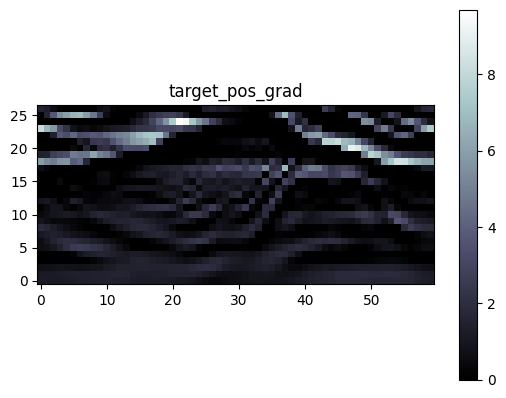

In [7]:
# Step 3: Positive spectral gradient extraction Eq.(3)
# in this step, both traget and template max diffrence over frequncy is calculated
# ----
target_pos_grad = np.zeros([target_filt_rmsdB.shape[0]-1,target_filt_rmsdB.shape[1],target_filt_rmsdB.shape[2]])
template_pos_grad = np.zeros([target_filt_rmsdB.shape[0]-1,target_filt_rmsdB.shape[1],target_filt_rmsdB.shape[2]])
# Calculate the gradient
for f_idx in range(target_filt_rmsdB.shape[0]-1):
    target_pos_grad[f_idx,:,:]   = target_filt_rmsdB[f_idx+1,:,:] - target_filt_rmsdB[f_idx,:,:]
    template_pos_grad[f_idx,:,:] = template_filt_rmsdB[f_idx+1,:,:] - template_filt_rmsdB[f_idx,:,:]
# Take only the positive values
target_pos_grad[target_pos_grad < 0] = 0
template_pos_grad[template_pos_grad < 0] = 0

# Display using imshow
plt.imshow(target_pos_grad[:,:,0], cmap='bone', origin='lower')
plt.colorbar()  # Add colorbar
plt.title("target_pos_grad")
plt.show()

sigma shape:  (60, 60, 2)


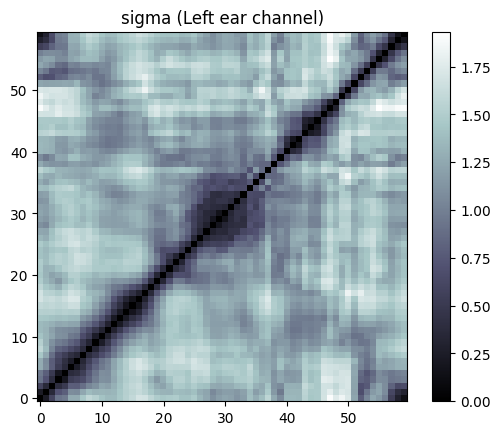

In [8]:
# Step 4: Comparison process Eq.(4)
# in this step, calculate the L1 norm between the target and the template avarage over frequncy and for each direction
# ----
def calc_L1_template_target(tem,tar):
    # Initialize sigma array
    sigma = np.zeros((tem.shape[1], tar.shape[1], tem.shape[2]))

    # Loop over time and angle indices
    for itang in range(tar.shape[1]):
        # replecate the target for each angle
        tmp = tar[:, itang, :]
        tmp = tmp[:, np.newaxis,:]
        tmp = np.tile(tmp,(1,tar.shape[1],1))
        isd = tmp - tem
        sigma[:, itang, :,] = np.mean(np.abs(isd), axis=0)
    return sigma



sigma = calc_L1_template_target(template_pos_grad,target_pos_grad)

print("sigma shape: ",sigma.shape)
# Display using imshow
plt.imshow(sigma[:,:,0], cmap='bone', origin='lower')
plt.colorbar()  # Add colorbar
plt.title("sigma (Left ear channel)")
plt.show()

si shape:  (60, 60, 2)


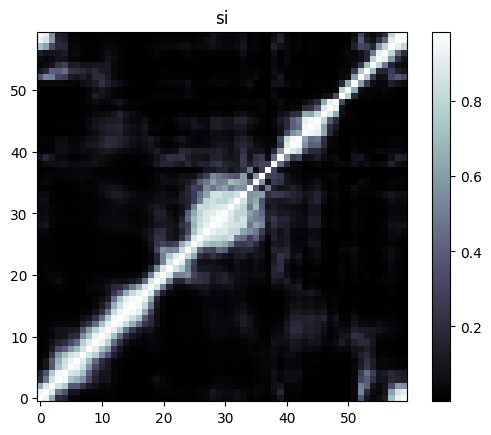

In [9]:
# Step 5: Similarity estimation Eq.(5)
# in this step, The L1 comparison (distance metric) is translated into the response probability (si)
# ----
# Constants
gamma = 6  # Example value for gamma
S = 0.7  # Example value for S
eps = np.finfo(float).eps  # Machine epsilon
si = np.zeros(sigma.shape)
# Loop over channels and iterations
for ch in range(sigma.shape[2]):
    for it in range(sigma.shape[1]):
        si[:, it, ch] = 1 + eps - (1 + np.exp(-gamma * (sigma[:, it, ch] - S)))**-1

print("si shape: ",si.shape)
# Display using imshow
plt.imshow(si[:,:,0], cmap='bone', origin='lower')
plt.colorbar()  # Add colorbar
plt.title("si")
plt.show()

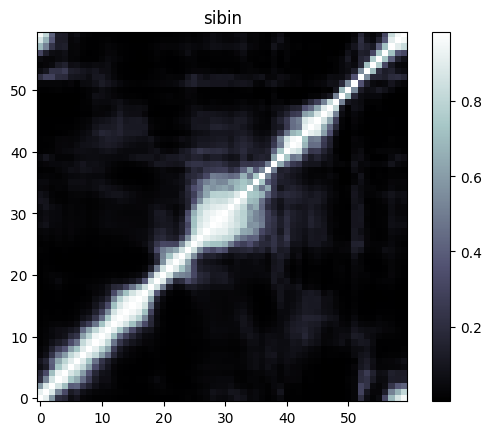

In [10]:
# Step 6: Binaural weighting Eq.(6)
# in this step, The left and right ear si matrices are waigted with one another, here we use the lat parameter to give "off median" results
# ----
# parameters
lat = 0
bwcoef = 13
# Compute the weight of left ear signal
binw = 1 / (1 + np.exp(-lat / bwcoef))
# Compute sibin
sibin = binw * si[:, :, 0] + (1 - binw) * si[:, :, 1]



# Display using imshow
plt.imshow(sibin, cmap='bone', origin='lower')
plt.colorbar()  # Add colorbar
plt.title("sibin")
plt.show()

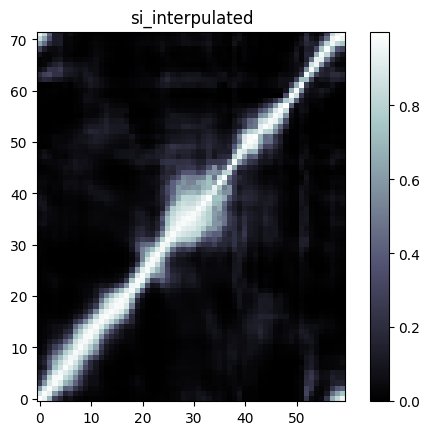

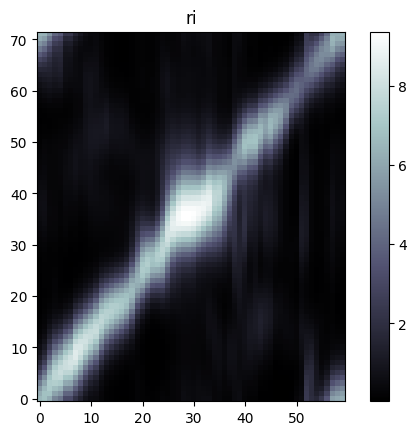

In [21]:
# Step 7: Sensorimotor mapping Eq.(7)
# In this step, the listener's auditory perception (captured by si) is translated into a motor response. 
# This translation is modeled using circular convolution between the auditory perception and a von Mises Probability Density Function (PDF). 
# Additionally, the si response is interpolated beforehand to more angles (with equal distances) using spline interpolation.
# ----
# parameters
mrsmsp = 17 # This is the PDF parameter it controls the "smearing" effect

def pconv(x, h):
    """
    Perform periodic convolution of 1D arrays x and h.
    """
    N = len(x)
    M = len(h)
    y = np.zeros(N)
    for n in range(N):
        for m in range(M):
            y[n] += h[m] * x[(n - m) % N]
    return y
    
def interpolate_si(si, polsamp, rangsamp, do_regular):
    if do_regular:
        rang0 = np.ceil(np.min(polsamp) * (1 / rangsamp)) * rangsamp
        rang = np.arange(rang0, np.max(polsamp) + rangsamp, rangsamp)
        siint = np.zeros((len(rang), si.shape[1]))

        for tt in range(si.shape[1]):
            interp_func = make_interp_spline(polsamp, si[:, tt], k=3)
            siint[:, tt] = interp_func(rang)

        si = siint
        si[si < 0] = 0  # Ensure SIs are positive (necessary due to spline interpolation)
    else:
        rang = polsamp

    return rang, si

# Example usage:
kv_polsamp = np.rad2deg(coardinate_median_plane.polar) # Polar angular sampling from the .sofa file

kv_rangsamp = 5  # Example rangsamp value
flags_do_regular = True  # Example do_regular value

rang, si_interpulated = interpolate_si(sibin, kv_polsamp, kv_rangsamp, flags_do_regular)


mrs = mrsmsp/np.cos(np.deg2rad(lat)); # direction dependent scatter (derivation: const. length rel. to the circumferences of circles considered as cross sections of a unit sphere)
x = np.arange(0, 2*np.pi, 2*np.pi/len(rang))
kappa = 1/np.deg2rad(mrs)**2; # concentration parameter (~1/sigma^2 of normpdf)
mrspdf = np.exp(kappa * np.cos(x)) / (2 * np.pi * i0(kappa)) # von Mises PDF

# Perfome the periodic convolution betweern the interpulated si and the PDF
ri = si_interpulated.copy()
for tt in range(si_interpulated.shape[1]):
    ri[:, tt] = pconv(si_interpulated[:, tt], mrspdf)
    

# Display using imshow
plt.imshow(si_interpulated, cmap='bone', origin='lower')
plt.colorbar()  # Add colorbar
plt.title("si_interpulated")
plt.show()

plt.imshow(ri, cmap='bone', origin='lower')
plt.colorbar()  # Add colorbar
plt.title("ri")
plt.show()



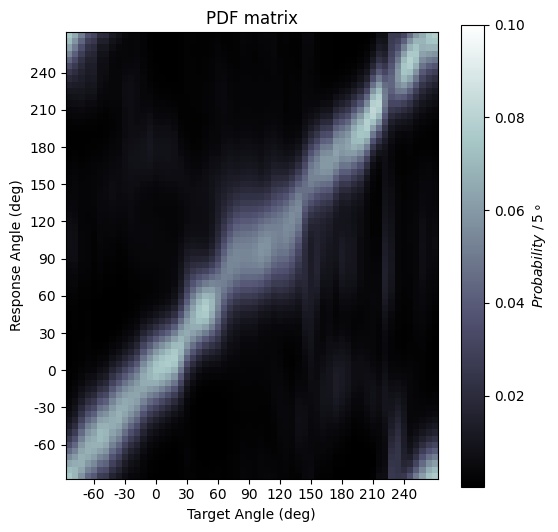

In [22]:
# Step 8: Normalization to probabilities Eq.(8)
# In this step, generate the probability mass vector (PMV) by normalizing the ri results so that each column is equal to one.
# ----
p = ri / (np.sum(ri, axis=0) + eps)

pdf = p
pdf = np.expand_dims(pdf, axis=2)
response_angle = np.atleast_2d(rang).T
target_angle = np.atleast_2d(kv_polsamp)
tang = np.squeeze(target_angle)
rang = np.squeeze(response_angle)

x_labels = np.floor(np.linspace(target_angle[0,0],target_angle[0,-1],target_angle[0].shape[0])).astype(int).astype(str)
y_labels = np.floor(np.linspace(response_angle[:,0][0],response_angle[:,0][-1],response_angle[:].shape[0])).astype(int).astype(str)

x_labels = np.floor(np.linspace(-60,target_angle[0][-1],target_angle[0].shape[0])).astype(int).astype(str)
y_labels = np.floor(np.linspace(-60,response_angle[:,0][-1],response_angle[:].shape[0])).astype(int).astype(str)


x_labels = np.arange(-60, target_angle[0][-1], 30).astype(int)
y_labels = np.arange(-60, response_angle[:,0][-1], 30).astype(int)


# Calculate absolute differences between each angle in a and a_label
absolute_diff = np.abs(target_angle[0] - x_labels.reshape(-1, 1))
# Find the indices of the 10 closest angles in a to each angle in a_label
closest_indices_x = np.argmin(absolute_diff, axis=1)

# Calculate absolute differences between each angle in a and a_label
absolute_diff = np.abs(response_angle[:,0] - y_labels.reshape(-1, 1))
# Find the indices of the 10 closest angles in a to each angle in a_label
closest_indices_y = np.argmin(absolute_diff, axis=1)


plt.figure(figsize=(6, 6))  # Specify the size directly when creating the figure
plt.imshow(pdf[:,:], cmap='bone', origin='lower', vmax=0.1)
cbar = plt.colorbar()  # Add colorbar
# Set x and y axis ticks
plt.xticks(closest_indices_x, x_labels)
plt.yticks(closest_indices_y, y_labels)
#plt.xticks(np.arange(tang[0]-5, tang[-1]+6, 30))
#plt.yticks(np.arange(rang[0]-5, rang[-1]+6, 30))
#plt.minorticks_on()

plt.xlabel('Target Angle (deg)')
plt.ylabel('Response Angle (deg)')
cbar.set_label(r'$Probability \,\, / \, 5\circ$')
plt.title("PDF matrix")
plt.show()


## Calculate Performance Predictions

In [25]:
def circular_stats_from_pdf(pdf, response, target):
    """
    Compute descriptive statistics for modeled median plane localization.

    Parameters
    ----------
    pdf : numpy array
        Probability density function of the modeled localization performance of
        shape R x T x N, with R being the number of response angles, T the
        number of target angles and N the number of subjects.
    response : numpy array
        Response polar angle in degree of shape R x 1. The polar angle is the
        angle along the median sagittal plane, with -90 being below, 0 to the
        front, 90 above, and 180 behind the subject.
    target : numpy array
        Response target angle in degree of shape 1 x T.

    Returns
    -------
    local_pe : numpy array
        RMS polar error in degree according to [1]_ Eq. (10) at each target
        angle. Array of shape T X S.
    local_qe : numpy array
        Quadrant error in percent according to [1]_ Eq. (9) at each target
        angle. Array of shape T X S.
    circ_mean : numpy array
        Circular mean in degree according to [2]_. Array of shape T x S.
    circ_var : numpy array
        Circular variance between 0 and 1 according to [2]_. Array of
        shape T x S.
    circ_std : numpy array
        Circular standard deviation between 0 and infinity according to [2]_.
        Array of shape T x S.

    References
    ----------
    .. [1] Baumgartner, R., Majdak, P., & Laback, B. (2014). Modeling sound-
           source localization in sagittal planes for human listeners. Journal
           of the Acoustical Society of America, 136(2), 791–802.
           https://doi.org/10.1121/1.4887447
    .. [2] Fisher, N. I. (1993). Statistical Analysis of Circular Data.
           Cambridge University Press.
    """

    # append dimension for correct broadcasting
    if pdf.ndim == 3:
        response = response[..., None]
        target = target[..., None]

    # mean resultant vector R using complex numbers
    # 0 <= abs(R) <= 1
    mean_resultant_complex = np.exp(1j * np.radians(response))
    mean_resultant_complex = np.sum(pdf * mean_resultant_complex, axis=0)

    # mean angle in degree
    circ_mean = np.angle(mean_resultant_complex, deg=True) % 360

    # circular standard deviation, 0 <= var <= 1
    circ_var = 1 - np.abs(mean_resultant_complex)

    # circular standard deviation, 0 <= std <= inf
    circ_std = np.sqrt(-2 * np.log(np.abs(mean_resultant_complex)))

    # distance between two angles
    delta_angle = np.abs(response - target)
    delta_angle = np.minimum(delta_angle, 360 - delta_angle)

    # mask local response angles
    local = delta_angle < 90

    # allocate error measures
    local_pe = np.zeros((pdf.shape[1], pdf.shape[2]))
    local_qe = np.zeros((pdf.shape[1], pdf.shape[2]))

    # loop target angles
    for tt in range(pdf.shape[1]):
        # current local response angles
        rr = local[:,tt].flatten()

        # polar error at target angle
        local_pe[tt] = np.sum(delta_angle[rr, tt]**2 * pdf[rr, tt], axis=0)
        local_pe[tt] = np.sqrt(local_pe[tt] / np.sum(pdf[rr, tt], axis=0))
        # quadrant error at target angle
        local_qe[tt] = np.sum(pdf[~rr, tt], axis=0) * 100

    return local_pe, local_qe, circ_mean, circ_var, circ_std



local_pe, local_qe, circ_mean, circ_var, circ_std = circular_stats_from_pdf(pdf, response_angle, target_angle)



print("Performance Predictions:")
print("------------------------")
print("Quadrant errors (%) ", f"{np.mean(local_qe):.1f}")
print("Local polar RMS error (deg) ", f"{np.mean(local_pe):.1f}")

print("circ_mean ", f"{np.mean(circ_mean):.1f}")
print("circ_var ", f"{np.mean(circ_var):.1f}")
print("circ_std ", f"{np.mean(circ_std):.1f}")




Performance Predictions:
------------------------
Quadrant errors (%)  14.2
Local polar RMS error (deg)  30.7
circ_mean  176.3
circ_var  0.3
circ_std  0.9
